In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

tqdm.pandas()

Matplotlib is building the font cache; this may take a moment.


In [ ]:
df = pd.read_csv('../data/embalces_urls.csv')
df.sample()

,URL
315,https://bogota.gov.co//mi-ciudad/habitat/racio...


In [3]:
def get_page_content(url):
    html = requests.get(url).content
    soup = BeautifulSoup(html)
    content_element = soup.find('div', {'class': 'v2024-article-wrapper'})

    return content_element.get_text()

df['html_content'] = df['URL'].progress_apply(get_page_content)
df.sample()

100%|██████████| 388/388 [05:57<00:00,  1.08it/s]


,URL,html_content
225,https://bogota.gov.co//mi-ciudad/habitat/racio...,Datos del consumo de agua del turno del marte...


In [4]:
spanish_months = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
month_map = {name: index for index, name in enumerate(spanish_months, start=1)}

def get_date(row):
    url = row['URL']
    day = re.search(r'-(\d{1,2})-', url)
    month = re.search(r'(' + '|'.join(spanish_months) + r')', url)
    year = re.search(r'-(\d{4})', url)
    
    if month and day and not year:
        year = re.search(r"\d{1,2}·[A-Z]+·(\d{4})", row['html_content'])

    if day and month and year:
        return datetime.datetime(int(year.group(1)), month_map[month.group(1)], int(day.group(1)))
        
    return pd.NA
    
df['date'] = df.progress_apply(get_date, axis=1)
df.sample(2)

100%|██████████| 388/388 [00:00<00:00, 66712.71it/s]


,URL,html_content,date
20,https://bogota.gov.co//mi-ciudad/habitat/racio...,Niveles de embalses y consumo de agua turno d...,2024-05-17 00:00:00
243,https://bogota.gov.co//mi-ciudad/habitat/sende...,¡Pilas! Senderos ecológicos de Bogotá siguen ...,<NA>


In [17]:
def found_percentages(row):
    content_text = row['html_content']
    found_list: list[str] = re.findall(r'(\d{2}[,.]\d{1,2})\s?%', content_text)
    return [float(f.replace(',', '.')) for f in found_list]

df['found_percentages'] = df.progress_apply(found_percentages, axis=1)
df.sample(2)

100%|██████████| 388/388 [00:00<00:00, 17022.20it/s]


,URL,html_content,date,found_percentages
156,https://bogota.gov.co//mi-ciudad/habitat/racio...,¡Te contamos! Consumo de agua en Bogotá del j...,2024-08-01 00:00:00,"[51.25, 51.25]"
125,https://bogota.gov.co//mi-ciudad/habitat/racio...,Conoce datos del consumo de agua en Bogotá de...,2024-08-28 00:00:00,[49.96]


In [45]:
with_valid_percentages = df['found_percentages'].apply(lambda x: len(x) > 0)
with_valid_dates = (~pd.isna(df['date'])) & (df['date'] <= datetime.datetime.now())

valid_entries = df[with_valid_percentages & with_valid_dates].drop_duplicates(subset='date')
valid_entries.sample(2)

,URL,html_content,date,found_percentages
184,https://bogota.gov.co//mi-ciudad/habitat/racio...,Datos del consumo de agua del lunes 16 de sep...,2024-09-16 00:00:00,"[45.81, 45.81]"
317,https://bogota.gov.co//mi-ciudad/habitat/racio...,Consumo de agua y nivel del embalses con cort...,2024-12-01 00:00:00,[52.37]


In [46]:
valid_entries['current_percentage'] = valid_entries['found_percentages'].progress_apply(lambda x: max(set(x), key=x.count))
valid_entries.sample(2)

100%|██████████| 282/282 [00:00<00:00, 590806.06it/s]


,URL,html_content,date,found_percentages,current_percentage
284,https://bogota.gov.co//mi-ciudad/habitat/balan...,Aquí el balance del consumo de agua en Bogotá...,2024-12-28 00:00:00,"[46.9, 46.9, 46.9]",46.9
263,https://bogota.gov.co//mi-ciudad/habitat/racio...,"El nivel del Sistema Chingaza, con corte al 9...",2024-11-09 00:00:00,"[48.0, 48.0]",48.0


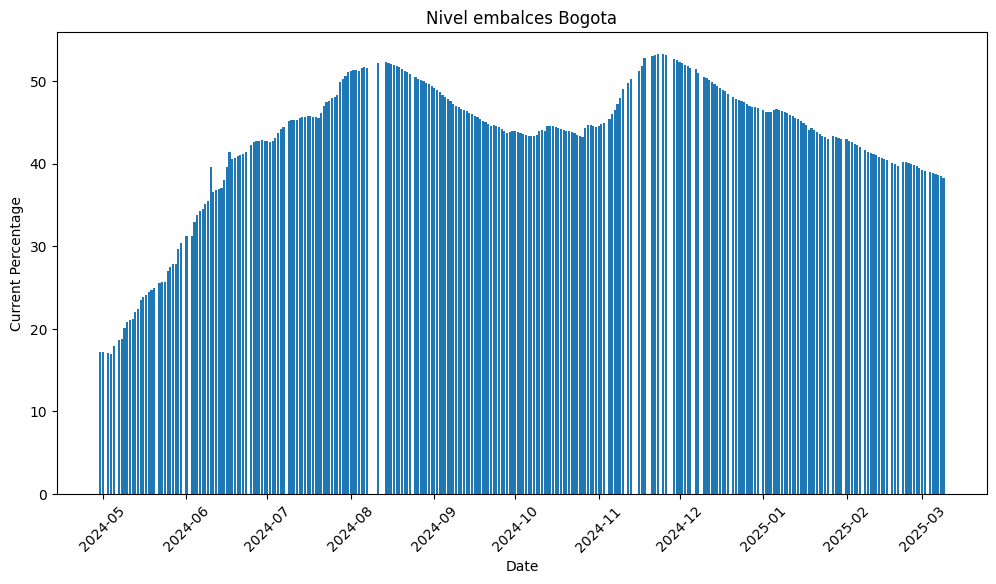

In [ ]:
# Ensure 'date' column is in datetime format
valid_entries['date'] = pd.to_datetime(valid_entries['date'])

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(valid_entries['date'], valid_entries['current_percentage'])
plt.xlabel('Date')
plt.ylabel('Current Percentage')
plt.title('Nivel embalses Bogota')
plt.xticks(rotation=45)
plt.show()